## Predicting online enrollment percentage using Random Forest,XGBoost and LightGBM Regressor

### Created in Nov 21, 2025
### Purpose: Using online enrollment percentage of 2012-2022 to predict 2023 online enrollment percentage (panel data)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor  # or other ML model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# (optional) For panel-data / fixed-effect modeling
from fixedeffect.fe import fixedeffect  # from package FixedEffectModel  OR
# or: import linearmodels (or pydynpd) for dynamic panel data modeling if desired

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans



In [2]:
# cluster = pd.read_csv('data_with_inst_clusters1027.csv')

data = pd.read_csv('initial_analyze1027.csv')

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/4229756228.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('initial_analyze1027.csv')


In [3]:
data = data.sort_values(['unitid', 'year'])
data = data.set_index(['unitid', 'year'])


In [4]:
data.columns

Index(['instnm', 'addr', 'city', 'stabbr', 'zip', 'fips', 'obereg', 'chfnm',
       'chftitle', 'gentele',
       ...
       'parent_merge', 'child_binary', 'n_unitid_year', 'shared_opeid_year',
       'erll_dist_perc', 'missing', 'close', 'pcert', 'pcertde',
       'hdegofr1_cat'],
      dtype='object', length=697)

In [5]:
# create lagged features
data['lag1_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(1)
data['lag2_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(2)
data['lag3_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(3)

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/2475385225.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag1_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(1)
/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/2475385225.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag2_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(2)
/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/2475385225.py:4: PerformanceWarning: DataFrame is highly fragment

In [6]:
# drop rows with missing values due to lagging
data = data.dropna(subset=['lag1_erll_perc'])

### Select features for prediction

### categorical features

### static, barely change with time
- fips: state
- hbcu: HBCU indicator
- tribal: tribal indicator
- locale: urbanicity
- instsize: size
- c21basic: carnegie classification 2021
- ccbasic : carnegie classification 2010



In [7]:
# make a new column urbanicity based on locale
# locale: 11,12,13 = City; 21,22,23 = Suburb; 31,32,33 = Town; 41,42,43 = Rural
# label define label_locale 11 "City: Large"
# label define label_locale 12 "City: Midsize",add
# label define label_locale 13 "City: Small",add
# label define label_locale 21 "Suburb: Large",add
# label define label_locale 22 "Suburb: Midsize",add
# label define label_locale 23 "Suburb: Small",add
# label define label_locale 31 "Town: Fringe",add
# label define label_locale 32 "Town: Distant",add
# label define label_locale 33 "Town: Remote",add
# label define label_locale 41 "Rural: Fringe",add
# label define label_locale 42 "Rural: Distant",add
# label define label_locale 43 "Rural: Remote",add
# label define label_locale -3 "{Not available}",add

# make locale below 0 is missing
data['locale'] = data['locale'].apply(lambda x: x if x > 0 else np.nan)
data['instsize'] = data['instsize'].apply(lambda x: np.nan if x < 0 else x)

data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/3063331624.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))


In [8]:
# instsize
# label define label_instsize 1 "Under 1,000"
# label define label_instsize 2 "1,000 - 4,999",add
# label define label_instsize 3 "5,000 - 9,999",add
# label define label_instsize 4 "10,000 - 19,999",add
# label define label_instsize 5 "20,000 and above",add
# label define label_instsize -1 "Not reported",add
# label define label_instsize -2 "Not applicable",add



In [9]:

# recode c21basic 
# label define label_c21basic 1 "Associate^s Colleges: High Transfer-High Traditional"
# label define label_c21basic 2 "Associate^s Colleges: High Transfer-Mixed Traditional/Nontraditional",add
# label define label_c21basic 3 "Associate^s Colleges: High Transfer-High Nontraditional",add
# label define label_c21basic 4 "Associate^s Colleges: Mixed Transfer/Career & Technical-High Traditional",add
# label define label_c21basic 5 "Associate^s Colleges: Mixed Transfer/Career & Technical-Mixed Traditional/Nontraditional",add
# label define label_c21basic 6 "Associate^s Colleges: Mixed Transfer/Career & Technical-High Nontraditional",add
# label define label_c21basic 7 "Associate^s Colleges: High Career & Technical-High Traditional",add
# label define label_c21basic 8 "Associate^s Colleges: High Career & Technical-Mixed Traditional/Nontraditional",add
# label define label_c21basic 9 "Associate^s Colleges: High Career & Technical-High Nontraditional",add
# label define label_c21basic 10 "Special Focus Two-Year: Health Professions",add
# label define label_c21basic 11 "Special Focus Two-Year: Technical Professions",add
# label define label_c21basic 12 "Special Focus Two-Year: Arts & Design",add
# label define label_c21basic 13 "Special Focus Two-Year: Other Fields",add
# label define label_c21basic 14 "Baccalaureate/Associate^s Colleges: Associate^s Dominant",add
# label define label_c21basic 15 "Doctoral Universities: Very High Research Activity",add
# label define label_c21basic 16 "Doctoral Universities: High Research Activity",add
# label define label_c21basic 17 "Doctoral/Professional Universities",add
# label define label_c21basic 18 "Master^s Colleges & Universities: Larger Programs",add
# label define label_c21basic 19 "Master^s Colleges & Universities: Medium Programs",add
# label define label_c21basic 20 "Master^s Colleges & Universities: Small Programs",add
# label define label_c21basic 21 "Baccalaureate Colleges: Arts & Sciences Focus",add
# label define label_c21basic 22 "Baccalaureate Colleges: Diverse Fields",add
# label define label_c21basic 23 "Baccalaureate/Associate^s Colleges: Mixed Baccalaureate/Associate^s",add
# label define label_c21basic 24 "Special Focus Four-Year: Faith-Related Institutions",add
# label define label_c21basic 25 "Special Focus Four-Year: Medical Schools & Centers",add
# label define label_c21basic 26 "Special Focus Four-Year: Other Health Professions Schools",add
# label define label_c21basic 27 "Special Focus Four-Year: Research Institutions",add
# label define label_c21basic 28 "Special Focus Four-Year: Engineering and Other Technology-Related Schools",add
# label define label_c21basic 29 "Special Focus Four-Year: Business & Management Schools",add
# label define label_c21basic 30 "Special Focus Four-Year: Arts, Music & Design Schools",add
# label define label_c21basic 31 "Special Focus Four-Year: Law Schools",add
# label define label_c21basic 32 "Special Focus Four-Year: Other Special Focus Institutions",add
# label define label_c21basic 33 "Tribal Colleges",add


# map carnegie types with c21basic
# c21basic 1-9 correspond to the carnegie 5
# c21basic 10-13 correspond to the carnegie 6
# c21basic 21 and 22 correspond to the carnegie 3
# c21basic 14 and 23 correspond to the carnegie 4
# c21basic 15-17 correspond to the carnegie 1
# c21basic 18-20 correspond to the carnegie 2
# c21basic 24-32 correspond to the carnegie 6
# c21basic 33 correspond to the carnegie 7

# label define label_harmonized 1 "Doctoral/Research Universities" ///
#                             2 "Master's Colleges & Universities" ///
#                             3 "Baccalaureate Colleges" ///
#                             4 "Baccalaureate/Associate's Colleges" ///
#                             5 "Associate's Colleges" ///
#                             6 "Special Focus Institutions" ///
#                             7 "Tribal Colleges" ///
#                             8 "Not applicable"

def map_carnegie(c21basic):
    if c21basic in range(1, 10):
        return 5
    elif c21basic in range(10, 14):
        return 6
    elif c21basic in [21, 22]:
        return 3
    elif c21basic == 14 or c21basic == 23:
        return 4
    elif c21basic in range(15, 18):
        return 1
    elif c21basic in range(18, 21):
        return 2
    elif c21basic in range(24, 33):
        return 6
    elif c21basic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie21'] = data['c21basic'].apply(map_carnegie)

data['carnegie21'].value_counts()



/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/4190505.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['carnegie21'] = data['c21basic'].apply(map_carnegie)


carnegie21
5.0    2482
2.0     706
1.0     685
4.0     387
3.0     247
6.0     101
7.0      87
Name: count, dtype: int64

In [10]:
# label define label_ccbasic 1 "Associate^s--Public Rural-serving Small"
# label define label_ccbasic 2 "Associate^s--Public Rural-serving Medium",add
# label define label_ccbasic 3 "Associate^s--Public Rural-serving Large",add
# label define label_ccbasic 4 "Associate^s--Public Suburban-serving Single Campus",add
# label define label_ccbasic 5 "Associate^s--Public Suburban-serving Multicampus",add
# label define label_ccbasic 6 "Associate^s--Public Urban-serving Single Campus",add
# label define label_ccbasic 7 "Associate^s--Public Urban-serving Multicampus",add
# label define label_ccbasic 8 "Associate^s--Public Special Use",add
# label define label_ccbasic 9 "Associate^s--Private Not-for-profit",add
# label define label_ccbasic 10 "Associate^s--Private For-profit",add
# label define label_ccbasic 11 "Associate^s--Public 2-year colleges under 4-year universities",add
# label define label_ccbasic 12 "Associate^s--Public 4-year Primarily Associate^s",add
# label define label_ccbasic 13 "Associate^s--Private Not-for-profit 4-year Primarily Associate^s",add
# label define label_ccbasic 14 "Associate^s--Private For-profit 4-year Primarily Associate^s",add
# label define label_ccbasic 15 "Research Universities (very high research activity)",add
# label define label_ccbasic 16 "Research Universities (high research activity)",add
# label define label_ccbasic 17 "Doctoral/Research Universities",add
# label define label_ccbasic 18 "Master^s Colleges and Universities (larger programs)",add
# label define label_ccbasic 19 "Master^s Colleges and Universities (medium programs)",add
# label define label_ccbasic 20 "Master^s Colleges and Universities (smaller programs)",add
# label define label_ccbasic 21 "Baccalaureate Colleges--Arts & Sciences",add
# label define label_ccbasic 22 "Baccalaureate Colleges--Diverse Fields",add
# label define label_ccbasic 23 "Baccalaureate/Associate^s Colleges",add
# label define label_ccbasic 24 "Theological seminaries, Bible colleges, and other faith-related institutions",add
# label define label_ccbasic 25 "Medical schools and medical centers",add
# label define label_ccbasic 26 "Other health professions schools",add
# label define label_ccbasic 27 "Schools of engineering",add
# label define label_ccbasic 28 "Other technology-related schools",add
# label define label_ccbasic 29 "Schools of business and management",add
# label define label_ccbasic 30 "Schools of art, music, and design",add
# label define label_ccbasic 31 "Schools of law",add
# label define label_ccbasic 32 "Other special-focus institutions",add
# label define label_ccbasic 33 "Tribal Colleges",add
# label define label_ccbasic -2 "Not applicable, not in Carnegie universe (not accredited or nondegree-granting)",add


def map_carnegie10(ccbasic):
    if ccbasic in range(1, 15):
        return 5
    elif ccbasic in range(15, 18):
        return 1
    elif ccbasic in range(18, 21):
        return 2
    elif ccbasic in range(21, 23):
        return 3
    elif ccbasic == 23:
        return 4
    elif ccbasic in range(24, 33):
        return 6
    elif ccbasic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie10'] = data['ccbasic'].apply(map_carnegie10)

data['carnegie10'].value_counts()

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_82836/1206042238.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['carnegie10'] = data['ccbasic'].apply(map_carnegie10)


carnegie10
5.0    10409
2.0     2788
1.0     1935
3.0      980
7.0      278
4.0      264
6.0      233
Name: count, dtype: int64

#### Numerical variables

- erll_dist_perc: online enrollment percentage
- lag1_erll_perc: one year lag of online enrollment percentage
- lag2_erll_perc: two year lag of online enrollment percentage
- eftotlt3:  Undergraduate, degree/certificate-seeking student in total (Undergraduate: A student enrolled in a 4- or 5-year bachelor's degree program, an associate's degree program, or a vocational or technical program below the baccalaureate.  )

In [11]:
# only keep categorical variables and lagged features
data = data[['fips', 'hbcu','tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10', 'eftotlt3','lag1_erll_perc', 'lag2_erll_perc', 'erll_dist_perc']]

In [12]:
# make 'fips', 'hbcu', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10' categorical variables
data['fips'] = data['fips'].astype('category')
data['hbcu'] = data['hbcu'].astype('category')
data['tribal'] = data['tribal'].astype('category')
data['urbanicity'] = data['urbanicity'].astype('category')
data['instsize'] = data['instsize'].astype('category')
data['carnegie21'] = data['carnegie21'].astype('category')
data['carnegie10'] = data['carnegie10'].astype('category')
# one-hot encoding for categorical variables will be done in modeling step
data =pd.get_dummies(data, columns=['fips', 'hbcu', 'tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10'], drop_first=True)

In [13]:
data.columns

Index(['eftotlt3', 'lag1_erll_perc', 'lag2_erll_perc', 'erll_dist_perc',
       'fips_2', 'fips_4', 'fips_5', 'fips_6', 'fips_8', 'fips_9', 'fips_10',
       'fips_11', 'fips_12', 'fips_13', 'fips_15', 'fips_16', 'fips_17',
       'fips_18', 'fips_19', 'fips_20', 'fips_21', 'fips_22', 'fips_23',
       'fips_24', 'fips_25', 'fips_26', 'fips_27', 'fips_28', 'fips_29',
       'fips_30', 'fips_31', 'fips_32', 'fips_33', 'fips_34', 'fips_35',
       'fips_36', 'fips_37', 'fips_38', 'fips_39', 'fips_40', 'fips_41',
       'fips_42', 'fips_44', 'fips_45', 'fips_46', 'fips_47', 'fips_48',
       'fips_49', 'fips_50', 'fips_51', 'fips_53', 'fips_54', 'fips_55',
       'fips_56', 'fips_60', 'fips_64', 'fips_66', 'fips_68', 'fips_69',
       'fips_70', 'fips_72', 'fips_78', 'hbcu_2', 'tribal_2',
       'urbanicity_Rural', 'urbanicity_Suburb', 'urbanicity_Town',
       'instsize_2.0', 'instsize_3.0', 'instsize_4.0', 'instsize_5.0',
       'carnegie21_2.0', 'carnegie21_3.0', 'carnegie21_4.0', 'car

### Split into train/test respecting time ordering

In [14]:
train = data[data.index.get_level_values('year') <= 2022]
test = data[data.index.get_level_values('year') > 2022]
X_train = train.drop(columns=['erll_dist_perc'])
y_train = train['erll_dist_perc']
X_test = test.drop(columns=['erll_dist_perc'])
y_test = test['erll_dist_perc']

### XGBoost, Random Forest and LightGBM

In [15]:

#  XGBoost
model_xgb = XGBRegressor(n_estimators=100, random_state=0)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost Test MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost Test MAE:", mean_absolute_error(y_test, y_pred_xgb))

# change the regressor to Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Random Forest Test MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest Test MAE:", mean_absolute_error(y_test, y_pred_rf))

# # change the regressor to LightGBM
# import lightgbm as lgb
# model_lgb = lgb.LGBMRegressor(n_estimators=100, random_state=0)
# model_lgb.fit(X_train, y_train)
# y_pred_lgb = model_lgb.predict(X_test)
# print("LightGBM Test MSE:", mean_squared_error(y_test, y_pred_lgb))
# print("LightGBM Test MAE:", mean_absolute_error(y_test, y_pred_lgb))



XGBoost Test MSE: 81.87119696370917
XGBoost Test MAE: 5.851851200887533
Random Forest Test MSE: 82.2599792279563
Random Forest Test MAE: 6.068862986352584


### Interpretation

- XGBoost: Test MSE: ~ 81.9, Test MAE: ~ 5.9
- Random Forest: Test MSE: ~ 82.3, Test MAE: ~ 6.1
- LightGBM: Test MSE: ~ 58.8, Test MAE: ~ 5.1

- LightGBM: On average, the prediction is about 5.1 percentage points off from the true value. Typical predictions (in squared-error sense) are off by ~8 points. LightGBM is doing the best job at predicting the outcome in terms of both average error and penalizing large errors.

- Heterogeneity across institutions: Given the  panel data (1000+ institutions, short panel), a global model like LightGBM may do well overall, but might perform poorly for some sub-types of institutions.

- The test set likely reflects similar conditions to training; if in future years institutions behave differently (policy changes, shocks, nonstationarity), performance may degrade. ML models trained on past patterns can fail when the underlying data-generation process changes


In [16]:
# check R squred of all models
from sklearn.metrics import r2_score
# r2_lgb = r2_score(y_test, y_pred_lgb)
# print("LightGBM Test R-squared:", r2_lgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Test R-squared:", r2_xgb)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Test R-squared:", r2_rf)

XGBoost Test R-squared: 0.7560732101387175
Random Forest Test R-squared: 0.7549148734685593


- Roughly 82% of the variation in the outcome is being explained by the model. The model captures a fairly large share of the variation — which is quite substantial, especially in institutional data settings.

- R^2 has limitations. With panel / time-series data, high R^2 might come from “persistence” rather than meaningful predictive structure — if your outcome tends to move slowly over time (high autocorrelation), a model that mostly predicts “same as last year / small change” may get high 
R^2 but still do poorly at detecting real shifts or regime change. Scholars caution aboutover-interpreting R^2 in time-series / trending data

In [17]:
# residual plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Online Enrollment Percentage')
plt.ylabel('Predicted Online Enrollment Percentage')
plt.title('Actual vs Predicted Online Enrollment Percentage')
plt.show()

NameError: name 'y_pred_lgb' is not defined

<Figure size 1000x600 with 0 Axes>

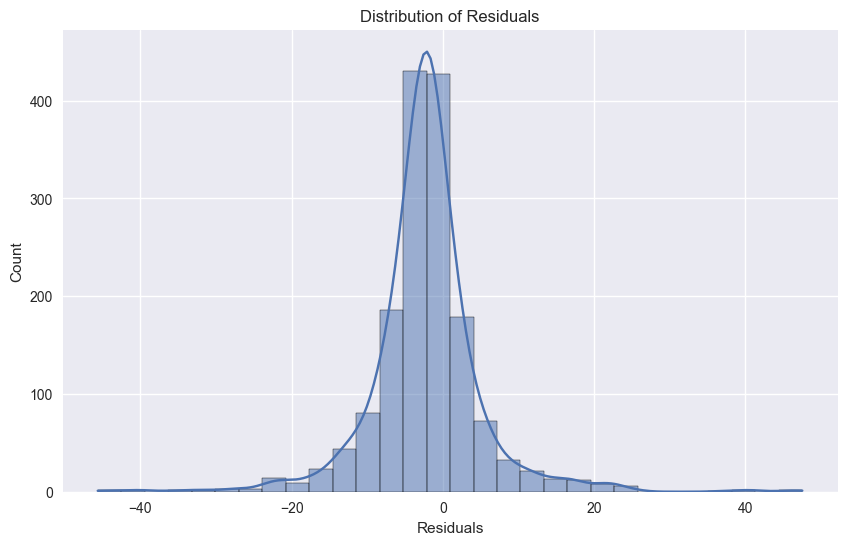

In [ ]:
# residual analysis
residuals = y_test - y_pred_lgb
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

- The model is not consistently over-predicting or under-predicting across the board, but there are some fairly large residuals in the tails

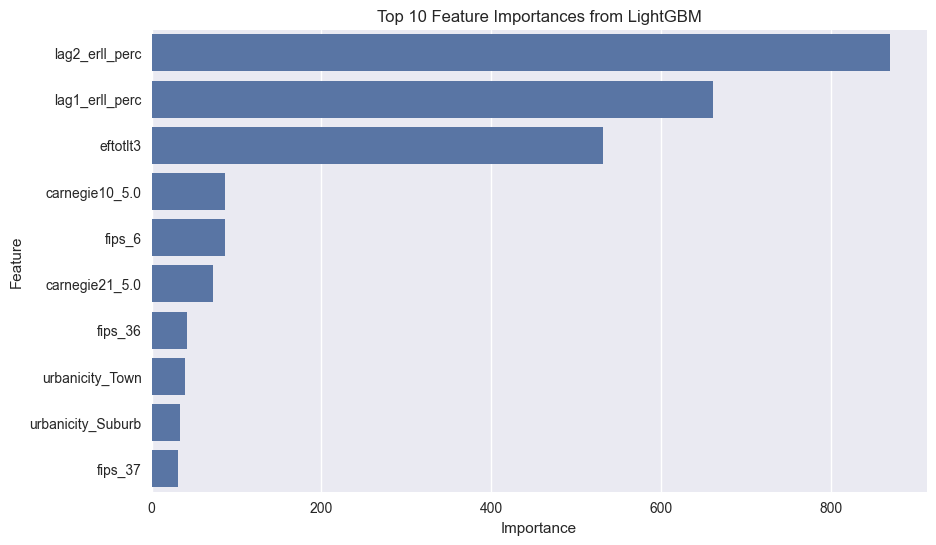

In [ ]:
# feature importance of LightGBM
importances = model_lgb.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# visualize feature importance of the top 10 features 
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances from LightGBM')
plt.show()


- The outcome appears to be highly autocorrelated (or “persistent”) over time: knowing last two years' value gives a lot of information about the next-year value. The data behaves like an autoregressive process: past values are powerful predictors of future value

In [ ]:
# diagnostic of institutions with residuals > 20
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lgb, 'Residual': residuals})
residuals_df = residuals_df[residuals_df['Residual'].abs() > 10]
residuals_df = residuals_df.sort_values(by='Residual', key=abs, ascending=False)
residuals_df.shape

(200, 3)

In [ ]:
# export residuals_df
residuals_df.to_csv('residuals_diagnostic.csv')

### Residuals Diagnostic

- There are 200 institutions with residuals above 10%. They can be identified as institutions with unpredictable changes in online enrollment in 2023. 
- There can also be data reporting issues that make the prediction not accurate.

In [ ]:
df = pd.read_csv('initial_analyze1027.csv')
# merge with residuals_df to get institution info
diagnostic_df = residuals_df.merge(df, left_index=True, right_on=['unitid', 'year'], how='left')


/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_61254/981130322.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('initial_analyze1027.csv')


In [ ]:
diagnostic_df['stabbr'].value_counts() # CA, TX, NC and NY

stabbr
CA    71
TX    12
NC    12
NY    11
NM     9
OH     9
NJ     7
OK     6
MA     6
FL     5
WA     4
WI     4
IL     3
PA     3
MN     3
MI     3
AR     3
SC     3
OR     2
LA     2
KS     2
NH     2
VA     2
ND     2
AZ     2
NE     2
TN     1
SD     1
MT     1
PR     1
WV     1
VT     1
MD     1
MP     1
IN     1
ME     1
Name: count, dtype: int64

In [ ]:
diagnostic_df['iclevel'].value_counts() # most of them are at lease 2 but less than 4 year institutions

iclevel
2    129
1     71
Name: count, dtype: int64

### 
- Assiciate's colleges (1-9) are having unpredictable changes in online enrollment in 2023.
- 129 out of 200 institutions are associate's colleges with unpredictable changes (> 10%) in online enrollment in 2023.
- CA, TX, NC, NY has 106 institutions with unpredictable changes, which may reflect on their state policy changes.

In [ ]:
diagnostic_df['c21basic'].value_counts() # most of them are associate's colleges


c21basic
1.0     27
2.0     19
6.0     19
3.0     18
4.0     17
15.0    17
33.0    14
14.0    14
8.0      8
5.0      8
18.0     7
9.0      7
7.0      6
23.0     4
16.0     4
20.0     3
19.0     2
22.0     2
29.0     1
21.0     1
27.0     1
17.0     1
Name: count, dtype: int64